##### Import modules

In [1]:
# import modules
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup
import re

import matplotlib.pyplot as plt

### Import Data

In [2]:
# read crafting plan csv from google sheets
sheet_id = '15ooJmi30BiE3ZhbNsGNG0Ct2gL-tRcoFMbLKLjQGqbU'  # ESO Mat Prices
sheet_name = 'plans'

url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'

plans = pd.read_csv(url)


In [3]:
# read patch data csv from google sheets
sheet_name = 'patches'
url = f'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}'
patches = pd.read_csv(url)

In [4]:
patches.tail(5)

,Update,Patch,Release,PTS
8,32,The Deadlands,11-01-21,09-20-21
9,33,Ascending Tide,03-13-22,01-31-22
10,34,High Isle,06-06-22,04-18-22
11,35,Lost Depths,08-22-22,07-11-22
12,36,Firesong,11-01-22,09-19-22


In [5]:
plans.head(5)

,Update,Name,Type,REG,BAS,HW,OCH,AR,MR,DW,CP
0,Scalebreaker,"Elsweyr Cage, Filigree",Workshop,15.0,NaN,NaN,10.0,12.0,NaN,9.0,NaN
1,Scalebreaker,"Elsweyr Cart, Masterwork",Courtyard,15.0,NaN,15.0,8.0,12.0,NaN,NaN,NaN
2,Scalebreaker,"Elsweyr Chaise Lounge, Upholstered",Parlor,NaN,15.0,15.0,8.0,12.0,NaN,NaN,NaN
3,Scalebreaker,"Elsweyr Gate, Masterwork",Structures,15.0,NaN,NaN,10.0,10.0,13.0,NaN,NaN
4,Scalebreaker,"Elsweyr Incense, Fragrant",Undercroft,NaN,NaN,13.0,10.0,13.0,NaN,9.0,NaN


### Clean Data

In [6]:
# rename columns
cols = [
    'Patch',
    'Name',
    'Category',
    'Regulus',
    'Bast',
    'Wood',
    'Ochre',
    'Resin',
    'Rune',
    'Wax',
    'Pelt',
]
plans.columns = cols

# replace nan with 0
plans = plans.fillna(0)

In [7]:
plans.tail(5)

,Patch,Name,Category,Regulus,Bast,Wood,Ochre,Resin,Rune,Wax,Pelt
684,Lost Depths,"High Isle Wall, Half-Timber",Structures,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
685,Lost Depths,"High Isle Wall, Thin Castle",Structures,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
686,Lost Depths,"High Isle Window, Turquoise",Structures,0.0,0.0,6.0,0.0,8.0,0.0,0.0,0.0
687,Lost Depths,"Potted Trees, Stonelore Dogwood",Conservatory,0.0,0.0,0.0,8.0,13.0,15.0,10.0,0.0
688,Lost Depths,"Shark Jaw, Massive",Gallery,0.0,0.0,0.0,0.0,12.0,0.0,11.0,15.0


### Get list of recently released crafting plans

In [8]:
# create a dataframe of new plan names from url
def get_plans(url):
    page = requests.get(url)

    soup = BeautifulSoup(page.content, "html.parser")
    data = soup.find_all('table')

    df = pd.read_html(str(data))[0]

    df = df[df['Source'].str.contains('Crafting') == True]
    
    df = df.reset_index(drop=True)

    df = df[['Name']]

    df['Name'] = df['Name'].str.replace(' \(page\)', '', regex=True)

    return df

In [9]:
# get all druidic plans from UESP.net
druid = get_plans('https://en.uesp.net/wiki/Online:Druid_Furnishings')
druid.head(5)

,Name
0,"Druidic Bed, Ivy Stone Double"
1,"Druidic Bed, Ivy Stone Single"
2,"Druidic Bed, Wood Single"
3,"Druidic Bench, Curved Stone"
4,"Druidic Bench, Ivy Curved Stone"


In [10]:
# get all high isle style plans from UESP.net
high_isle = get_plans('https://en.uesp.net/wiki/Online:High_Isle_Furnishings')
high_isle.head(5)

,Name
0,"Book Stack, Well-Read"
1,"High Isle Archway, Carved"
2,"High Isle Basket, Woven"
3,"High Isle Beacon, Unlit"
4,"High Isle Bed, Canopy Full"


In [11]:
# combine styles into update 36 dataframe
u36 = pd.concat([druid, high_isle])
u36.tail(10)

,Name
70,"High Isle Walkway, Curved Castle"
71,"High Isle Walkway, Straight Castle"
72,"High Isle Wall Mirror, Gilded"
73,"High Isle Wall, Half-Timber"
74,"High Isle Wall, Thin Castle"
75,"High Isle Wardrobe, Compass Rose"
76,"High Isle Wardrobe, Rustic"
77,"High Isle Window, Turquoise"
78,"Potted Trees, Stonelore Dogwood"
79,"Shark Jaw, Massive"


In [12]:
# filter out anything already included in plans df
u36 = u36[~u36['Name'].isin(plans['Name'])]
u36 = u36.reset_index(drop=True)
u36.shape

(50, 1)

##### Fill in missing information for new plans

In [13]:
# create dict of row values for new plans
def get_cols(plan_name):

    # create url for plan from Name col value
    # remove commas and replace spaces with dashes
    plan = plan_name.replace(',', '')
    plan = plan.replace(' ', '-')

    # convert to lowercase
    plan = plan.lower()

    plan_url = f'https://eso-hub.com/en/furniture/{plan}'

    # get all text from url
    page = requests.get(plan_url)
    soup = BeautifulSoup(page.content, "html.parser")
    data = soup.get_text()

    # create dictionary for column values
    plan_info = {}

    # patch
    plan_update = find_text(data, 'added to the game with the ', ' DLC')
    plan_info['Patch'] = plan_update

    # name
    plan_info['Name'] = plan_name

    # category
    plan_cat = find_text(data, 'ESO Housing Library - All Housing Items\n', '\n')
    plan_info['Category'] = plan_cat


    # materials list
    plan_mats = find_text(data, 'Ingredients', 'Required skills:')

    # fix formatting and convert into list
    plan_mats = re.sub(':\s+|\(|\)\s$|\)', '', plan_mats)
    plan_mats = plan_mats.splitlines()

    # create key:val pairs for columns and mat quantities
    plan_mats = mat_cols(plan_mats)

    # combine plan_info and plan_mats
    plan_cols = plan_info | plan_mats

    return plan_cols

In [14]:
def find_text(source, start, end):
    match = re.search(start, source)
    index = match.end()

    filtered = source[index:]

    match = re.search(end, filtered)
    index = match.start()

    filtered = filtered[:index]

    return filtered

In [15]:
# find relevant mats, remove mat name, and add quantity to plan_info
def mat_cols(material_list):

    mat_col = {}

    for material in material_list:
        if 'Regulus' in material:
            quantity = re.sub('Regulus ', '', material)
            quantity = int(quantity)
            mat_col['Regulus'] = quantity

        elif 'Bast' in material:
            quantity = re.sub('Bast ', '', material)
            quantity = int(quantity)
            mat_col['Bast'] = quantity

        elif 'Heartwood' in material:
            quantity = re.sub('Heartwood ', '', material)
            quantity = int(quantity)
            mat_col['Wood'] = quantity

        elif 'Ochre' in material:
            quantity = re.sub('Ochre ', '', material)
            quantity = int(quantity)
            mat_col['Ochre'] = quantity

        elif 'Alchemical Resin' in material:
            quantity = re.sub('Alchemical Resin ', '', material)
            quantity = int(quantity)
            mat_col['Resin'] = quantity

        if 'Mundane Rune' in material:
            quantity = re.sub('Mundane Rune ', '', material)
            quantity = int(quantity)
            mat_col['Rune'] = quantity

        elif 'Decorative Wax' in material:
            quantity = re.sub('Decorative Wax ', '', material)
            quantity = int(quantity)
            mat_col['Wax'] = quantity

        elif 'Clean Pelt' in material:
            quantity = re.sub('Clean Pelt ', '', material)
            quantity = int(quantity)
            mat_col['Pelt'] = quantity

    return mat_col

In [16]:
# fill missing data for each plan
for row, plan in enumerate(u36['Name']):
    # get plan info dictionary using ESO-HUB plan page
    col_data = get_cols(plan)

    # fill cols, with dict key as col name, dict value as col value
    for key, value in col_data.items():
        u36.at[row, key] = value

In [17]:
u36.head(10)

,Name,Patch,Category,Pelt,Wax,Rune,Resin,Bast,Wood,Ochre,Regulus
0,"Druidic Bed, Ivy Stone Double",Firesong,Suite,10.0,6.0,13.0,NaN,NaN,NaN,NaN,NaN
1,"Druidic Bed, Ivy Stone Single",Firesong,Suite,NaN,NaN,9.0,6.0,NaN,NaN,NaN,NaN
2,"Druidic Bed, Wood Single",Firesong,Suite,NaN,NaN,NaN,NaN,9.0,6.0,NaN,NaN
3,"Druidic Bench, Curved Stone",Firesong,Dining,NaN,NaN,9.0,6.0,NaN,NaN,NaN,NaN
4,"Druidic Bench, Ivy Curved Stone",Firesong,Dining,NaN,6.0,13.0,9.0,NaN,NaN,NaN,NaN
5,"Druidic Bench, Ivy Stone",Firesong,Dining,NaN,NaN,9.0,6.0,NaN,NaN,NaN,NaN
6,"Druidic Bookcase, Short Stone",Firesong,Library,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
7,"Druidic Bookcase, Tall Stone",Firesong,Library,NaN,NaN,9.0,6.0,NaN,NaN,NaN,NaN
8,"Druidic Bookcase, Tall Wood",Firesong,Library,NaN,5.0,NaN,NaN,NaN,9.0,NaN,NaN
9,"Druidic Bowl, Clay",Firesong,Hearth,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# copy column order of plans df
cols = plans.columns
u36 = u36[cols]

# replace NaN values for unused mats with 0s
u36 = u36.fillna(0)

In [19]:
u36.head(5)

,Patch,Name,Category,Regulus,Bast,Wood,Ochre,Resin,Rune,Wax,Pelt
0,Firesong,"Druidic Bed, Ivy Stone Double",Suite,0.0,0.0,0.0,0.0,0.0,13.0,6.0,10.0
1,Firesong,"Druidic Bed, Ivy Stone Single",Suite,0.0,0.0,0.0,0.0,6.0,9.0,0.0,0.0
2,Firesong,"Druidic Bed, Wood Single",Suite,0.0,9.0,6.0,0.0,0.0,0.0,0.0,0.0
3,Firesong,"Druidic Bench, Curved Stone",Dining,0.0,0.0,0.0,0.0,6.0,9.0,0.0,0.0
4,Firesong,"Druidic Bench, Ivy Curved Stone",Dining,0.0,0.0,0.0,0.0,9.0,13.0,6.0,0.0


In [20]:
# combine update 36 and plans dataframes
plans = pd.concat([plans, u36])
display(plans)

,Patch,Name,Category,Regulus,Bast,Wood,Ochre,Resin,Rune,Wax,Pelt
0,Scalebreaker,"Elsweyr Cage, Filigree",Workshop,15.0,0.0,0.0,10.0,12.0,0.0,9.0,0.0
1,Scalebreaker,"Elsweyr Cart, Masterwork",Courtyard,15.0,0.0,15.0,8.0,12.0,0.0,0.0,0.0
2,Scalebreaker,"Elsweyr Chaise Lounge, Upholstered",Parlor,0.0,15.0,15.0,8.0,12.0,0.0,0.0,0.0
3,Scalebreaker,"Elsweyr Gate, Masterwork",Structures,15.0,0.0,0.0,10.0,10.0,13.0,0.0,0.0
4,Scalebreaker,"Elsweyr Incense, Fragrant",Undercroft,0.0,0.0,13.0,10.0,13.0,0.0,9.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
45,Firesong,"High Isle Dresser, Wood",Suite,7.0,0.0,13.0,0.0,0.0,0.0,8.0,0.0
46,Firesong,"High Isle Fountain, Wall",Courtyard,7.0,0.0,0.0,0.0,9.0,13.0,0.0,0.0
47,Firesong,"High Isle Nightstand, Dainty Wood",Suite,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
48,Firesong,"High Isle Nightstand, Wood",Suite,0.0,0.0,9.0,0.0,0.0,0.0,5.0,0.0


### Analyze plans by update

In [21]:
plans.head(5)

,Patch,Name,Category,Regulus,Bast,Wood,Ochre,Resin,Rune,Wax,Pelt
0,Scalebreaker,"Elsweyr Cage, Filigree",Workshop,15.0,0.0,0.0,10.0,12.0,0.0,9.0,0.0
1,Scalebreaker,"Elsweyr Cart, Masterwork",Courtyard,15.0,0.0,15.0,8.0,12.0,0.0,0.0,0.0
2,Scalebreaker,"Elsweyr Chaise Lounge, Upholstered",Parlor,0.0,15.0,15.0,8.0,12.0,0.0,0.0,0.0
3,Scalebreaker,"Elsweyr Gate, Masterwork",Structures,15.0,0.0,0.0,10.0,10.0,13.0,0.0,0.0
4,Scalebreaker,"Elsweyr Incense, Fragrant",Undercroft,0.0,0.0,13.0,10.0,13.0,0.0,9.0,0.0


#### Sum of mats used by plans per update

In [22]:
mats_sum = plans.groupby('Patch').sum()
patches = patches.merge(mats_sum, how='left', on=['Patch'])

In [23]:
patches.head(10)

,Update,Patch,Release,PTS,Regulus,Bast,Wood,Ochre,Resin,Rune,Wax,Pelt
0,23,Scalebreaker,08-12-19,07-07-19,67.0,15.0,43.0,84.0,82.0,108.0,62.0,0.0
1,25,Harrowstorm,02-24-20,01-20-20,45.0,15.0,75.0,53.0,38.0,41.0,48.0,11.0
2,26,Greymoor,05-26-20,04-20-20,554.0,306.0,1366.0,404.0,371.0,223.0,799.0,207.0
3,27,Stonethorn,08-24-20,07-13-20,143.0,50.0,187.0,24.0,71.0,166.0,51.0,13.0
4,28,Markarth,11-02-20,09-21-20,379.0,47.0,115.0,70.0,49.0,287.0,24.0,14.0
5,29,Flames of Ambition,03-08-21,01-27-21,177.0,28.0,67.0,98.0,43.0,255.0,31.0,0.0
6,30,Blackwood,05-31-21,04-19-21,447.0,212.0,678.0,125.0,377.0,266.0,106.0,24.0
7,31,Waking Flame,08-23-21,07-12-21,193.0,15.0,164.0,45.0,52.0,173.0,76.0,13.0
8,32,The Deadlands,11-01-21,09-20-21,243.0,90.0,136.0,85.0,205.0,238.0,125.0,90.0
9,33,Ascending Tide,03-13-22,01-31-22,132.0,24.0,80.0,32.0,155.0,208.0,32.0,7.0


#### Total plans per update

In [24]:
total_plans = plans.groupby('Patch')['Name'].count()
patches = patches.merge(total_plans, how='left', on=['Patch'])

In [25]:
patches.head(5)

,Update,Patch,Release,PTS,Regulus,Bast,Wood,Ochre,Resin,Rune,Wax,Pelt,Name
0,23,Scalebreaker,08-12-19,07-07-19,67.0,15.0,43.0,84.0,82.0,108.0,62.0,0.0,13
1,25,Harrowstorm,02-24-20,01-20-20,45.0,15.0,75.0,53.0,38.0,41.0,48.0,11.0,7
2,26,Greymoor,05-26-20,04-20-20,554.0,306.0,1366.0,404.0,371.0,223.0,799.0,207.0,233
3,27,Stonethorn,08-24-20,07-13-20,143.0,50.0,187.0,24.0,71.0,166.0,51.0,13.0,31
4,28,Markarth,11-02-20,09-21-20,379.0,47.0,115.0,70.0,49.0,287.0,24.0,14.0,49


In [26]:
patches = patches.rename(columns={'Name':'Plans'})
patches.head(5)

,Update,Patch,Release,PTS,Regulus,Bast,Wood,Ochre,Resin,Rune,Wax,Pelt,Plans
0,23,Scalebreaker,08-12-19,07-07-19,67.0,15.0,43.0,84.0,82.0,108.0,62.0,0.0,13
1,25,Harrowstorm,02-24-20,01-20-20,45.0,15.0,75.0,53.0,38.0,41.0,48.0,11.0,7
2,26,Greymoor,05-26-20,04-20-20,554.0,306.0,1366.0,404.0,371.0,223.0,799.0,207.0,233
3,27,Stonethorn,08-24-20,07-13-20,143.0,50.0,187.0,24.0,71.0,166.0,51.0,13.0,31
4,28,Markarth,11-02-20,09-21-20,379.0,47.0,115.0,70.0,49.0,287.0,24.0,14.0,49


### Visualizations

In [27]:
# plot formatting etc

colors = {
    'regulus': '#98CABB',
    'bast': '#E9D985',
    'wood': '#ff6d00',
    'ochre': '#C4D9CE',
    'resin': '#eef0d0',
    'rune': '#46B0B1',
    'wax': '#F4B34E',
    'pelt': '#DBE3CE',
}  # wedge colors

labels = list(colors.keys())

pie = {'labeldistance': None, 'radius': 1}
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
legend = {
    'facecolor': None,
    'edgecolor': None,
    'fontsize': 8,
    'labelcolor': '#436161',
    'framealpha': 0,
}

subfnt = {'fontsize': 10, 'color': '#436161'}
countfnt = {
    'color': '#436161',
    'horizontalalignment': 'center',
    'verticalalignment': 'center',
    'alpha': 0.3
}

In [28]:
# adjust dataframes for plots

mats_sum = patches[['Patch', 'Regulus', 'Bast', 'Wood', 'Ochre', 'Resin', 'Rune', 'Wax', 'Pelt']]
mats_sum = mats_sum.set_index('Patch')
mats_sum = mats_sum.transpose()

total_plans = patches[['Patch', 'Plans']]
total_plans = total_plans.set_index('Patch')

updates = list(mats_sum.columns)

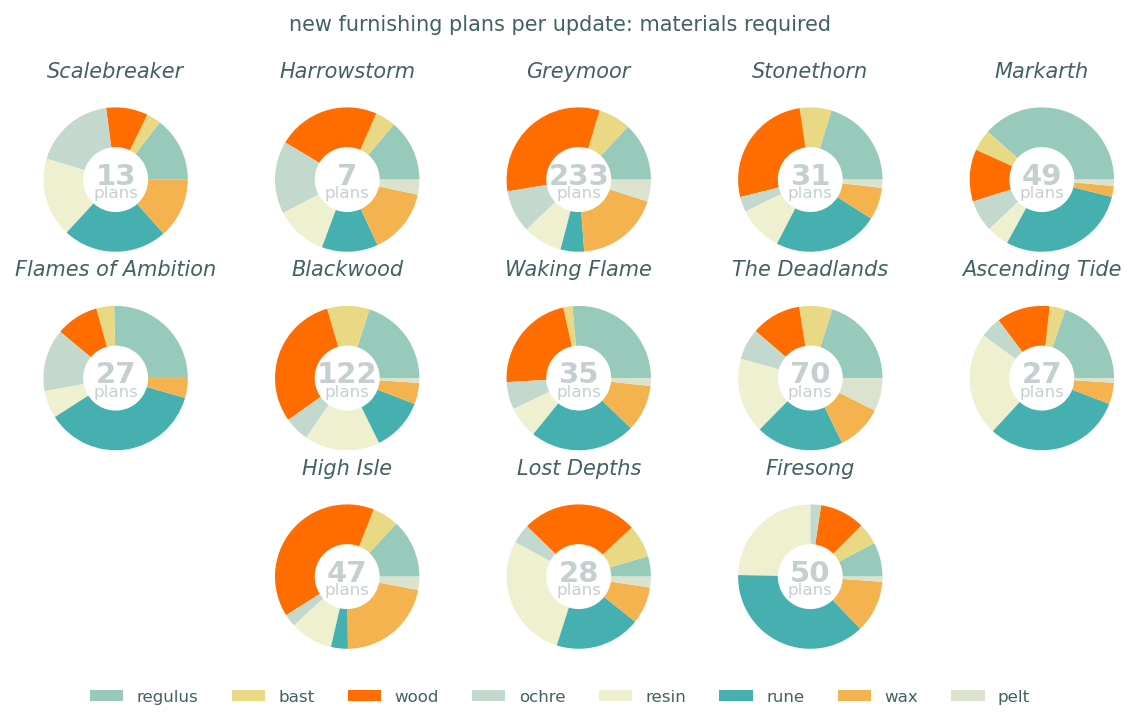

In [36]:
# pie charts for each update
fig, axs = plt.subplots(3, 5, dpi=150, figsize=(10, 5), facecolor='w')
plt.subplots_adjust(hspace=0.1, wspace=-0.02)
fig.suptitle('new furnishing plans per update: materials required', **subfnt)

for update, ax in zip(updates, axs.ravel()):
    mats_sum[update].plot.pie(
        ax=ax,
        labels=list(mats_sum.index),
        colors=[colors[key.lower()] for key in labels],
        wedgeprops = dict(width=0.55),
        **pie,
    )
    ax.set_title(label=update, style='italic', **subfnt)
    ax.set_ylabel('')
    ax.text(
        x=-0,
        y=0.05,
        s=(str(int(total_plans.at[update, 'Plans']))),
        weight='semibold',
        size=14,
        **countfnt,
    )
    # label for plan count at center of each pie chart
    ax.text(x=-0, y=-0.19, s='plans', size=8, weight='light', **countfnt)

plt.figlegend(labels=labels, loc='lower center', bbox_to_anchor=(0.5, 0.04), ncol=8, **legend)

second = axs[2][1].get_position()
third = axs[2][2].get_position()
fourth = axs[2][3].get_position()

# move last row of plots 1 space to the right
axs[2][0].set_position(second)
axs[2][1].set_position(third)
axs[2][2].set_position(fourth)

# remove empty plots
fig.delaxes(axs[2][3])
fig.delaxes(axs[2][4])

fig.savefig('images/CKy_mats_update.png', dpi=150)

*Materials Used in New Furnishing Plans per Update:* Pie charts showing the materials needed to make one of each new craftable furnishing introduced in an update (starting with Update 23: Scalebreaker), for the purpose of comparing how each update might affect demand for furnishing materials. The total number of plans added per update is shown in the center of each subplot.

In [30]:
# group by category and find the sum of each, & swap df rows/columns
cat_sum = plans.groupby(['Category']).sum()
cat_sum = cat_sum.transpose()

# get unique category names and sort alphabetically
categories = pd.unique(plans['Category'])
categories.sort()

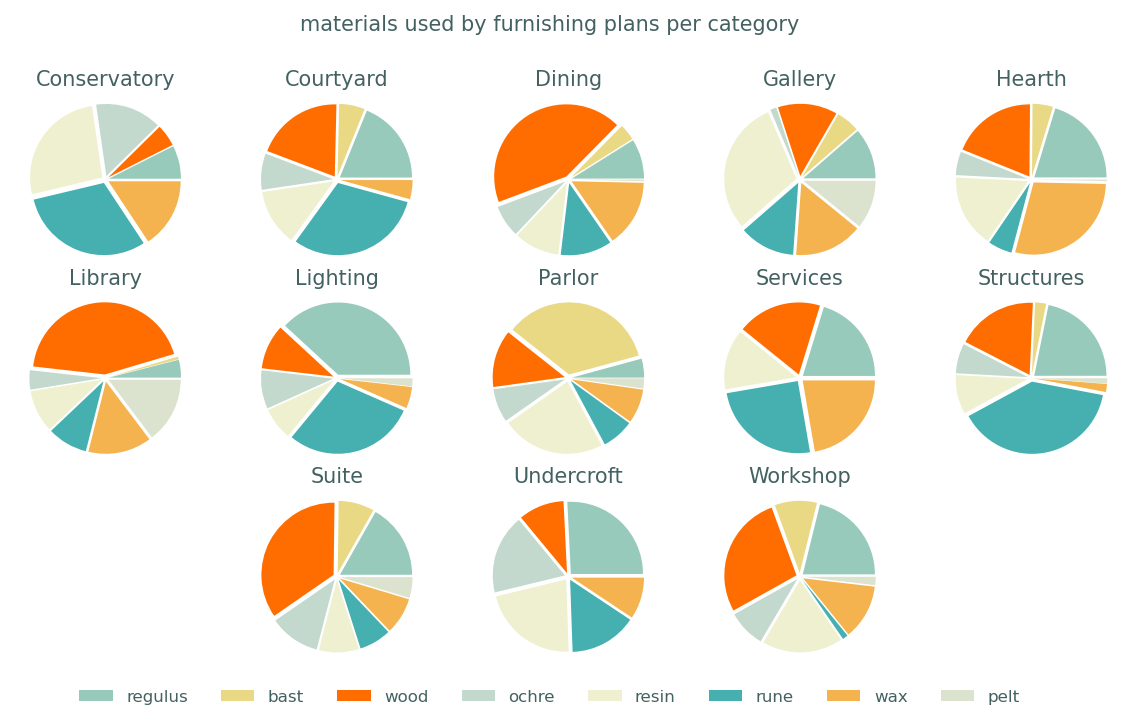

In [31]:
fig, axs = plt.subplots(3, 5, dpi=150, figsize=(10, 5), facecolor='w')
plt.subplots_adjust(hspace=0.1, wspace=-0.02)
fig.suptitle('materials used by furnishing plans per category', **subfnt)

# make a pie chart for each category's materials
for cat, ax in zip(categories, axs.ravel()):
    cat_sum[cat].plot.pie(
        ax=ax,
        labels=labels,
        explode=explode,
        colors=[colors[key] for key in labels],
        **pie,
    )
    ax.set_title(label=cat, pad=-4, **subfnt)
    ax.set_ylabel('')

plt.figlegend(labels=labels, loc='lower center', bbox_to_anchor=(0.5, 0.04), ncol=8, **legend)

second = axs[2][1].get_position()
third = axs[2][2].get_position()
fourth = axs[2][3].get_position()

# move last row of plots 1 space to the right
axs[2][0].set_position(second)
axs[2][1].set_position(third)
axs[2][2].set_position(fourth)

# remove empty plots
fig.delaxes(axs[2][3])
fig.delaxes(axs[2][4])

fig.savefig('images/CKy_mats_cat.png', dpi=100)

*Materials Used by Furnishing Plans per Category:* Pie charts showing mats used by all plans added from Scalebreaker to Lost Depths, sorted by furnishing type.

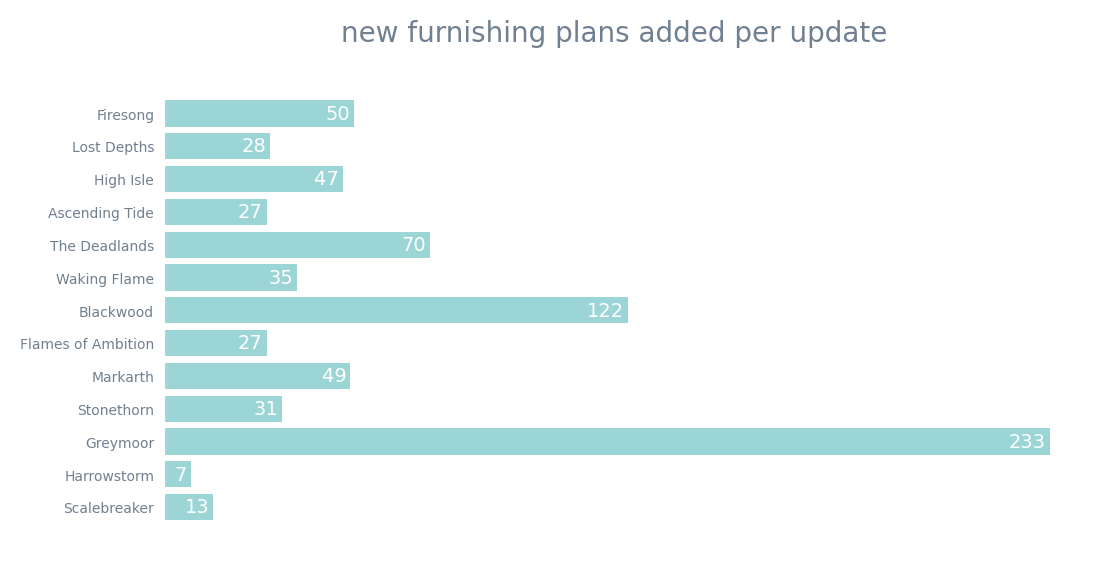

In [32]:
# create a horizontal bar chart of the number of plans released per patch
fig, ax = plt.subplots(dpi=200, figsize=(6, 3), facecolor='w')
fig.suptitle(
    'new furnishing plans added per update', c='slategrey', **subfnt
)

x = patches['Patch']
y = patches['Plans']

ax.barh(x, y, align='center', color='#58babb', alpha=0.6)
ax.tick_params(axis='x')
ax.tick_params(axis='y', labelsize=5, labelcolor='slategrey', size=0)
ax.get_xaxis().set_visible(False)

# hide spines
for spine in ax.spines.values():
    spine.set_edgecolor('w')

n = 0
for i in range(len(y)):
    ax.text(
        x=(y[n] - 1),
        y=n,
        s=str(int(y[n])),
        c='w',
        size=7,
        ha='right',
        va='center',
        weight=500,
    )
    n = n + 1

In [33]:
colors2 = [
    '#e7da7f',
    '#ff6d00',
    '#f78f17',
    '#eac459',
    '#e7eea6',
    '#f0ab37',
    '#eeffcd',
    '#d2f3c4',
    '#9ad9b9',
    '#62beb3',
    '#7eccb5',
    '#46b0b1',
    '#b6e6be'

    ]

cat_colors = dict(zip(categories, colors2))

#### Plan categories per update

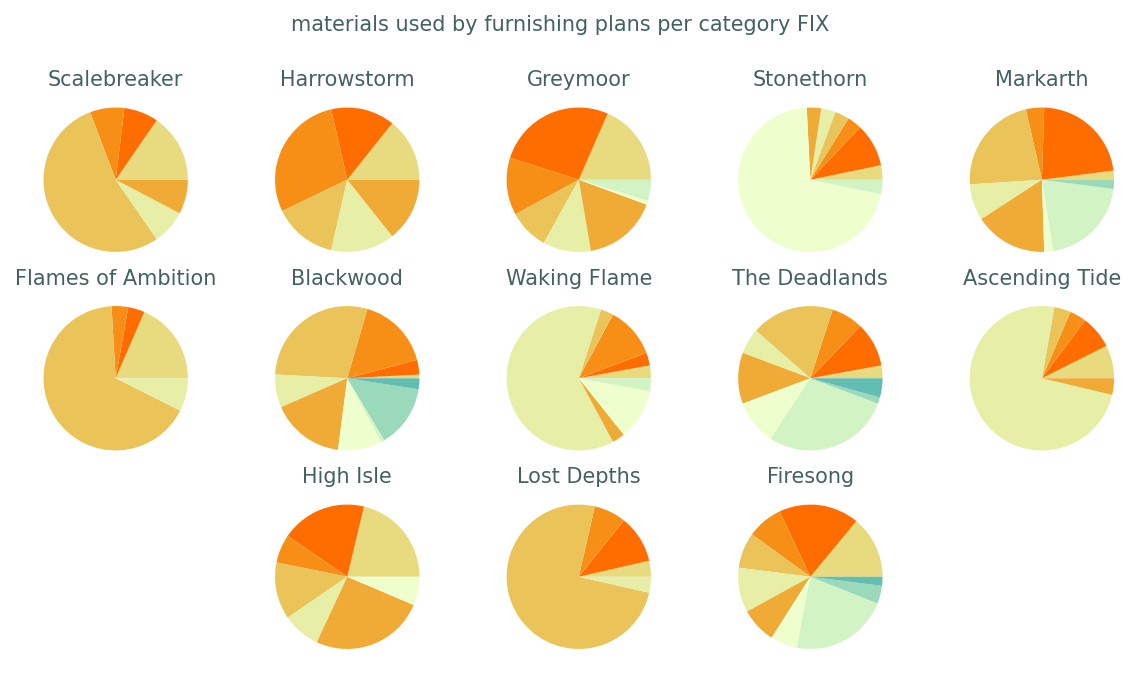

In [34]:
fig, axs = plt.subplots(3, 5, dpi=150, figsize=(10, 5), facecolor='w')
plt.subplots_adjust(hspace=0.1, wspace=-0.02)
fig.suptitle('materials used by furnishing plans per category FIX', **subfnt)

# make a pie chart for each category's materials
for update, ax in zip(updates, axs.ravel()):

    update_plans = plans.loc[plans['Patch'] == update]
    update_plans = update_plans.groupby('Category')['Patch'].count()

    update_plans.name = update

    update_plans.plot.pie(
        ax=ax,
        labels=categories,
        colors=[cat_colors[key] for key in categories],
        **pie,
    )
    ax.set_title(label=update, pad=-4, **subfnt)
    ax.set_ylabel('')

#axs[1][3].legend(loc='lower center', bbox_to_anchor=(-0.75, -1.5), ncol=8, **legend)

second = axs[2][1].get_position()
third = axs[2][2].get_position()
fourth = axs[2][3].get_position()

# move last row of plots 1 space to the right
axs[2][0].set_position(second)
axs[2][1].set_position(third)
axs[2][2].set_position(fourth)

# remove empty plots
fig.delaxes(axs[2][3])
fig.delaxes(axs[2][4])


#plt.figlegend(loc='lower center', bbox_to_anchor=(0.51, 0.5), ncol=7, **legend)

fig.savefig('images/CKy_mats_cat.png', dpi=100)